In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

from sklearn.metrics import make_scorer, f1_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel("Peoples_Climate_Vote_Database_2024_KNN_filled.xlsx")

In [3]:
df.head()

,Column1,ID,CID,QID,RID,EID,AID,Country,Question Text,Question Text (Short),Response,Education,Age,Weighted Mean,Cat ID,Category,Question Context,is_missing
0,60,60,1,13,1,1,1,Global,Should countries work together on climate chan...,Countries working together,Yes - they should work together despite their ...,All Education,All Ages,86.0,4,Peoples' call for collaboration,Climate change is a global problem that requir...,0
1,61,61,1,13,2,1,1,Global,Should countries work together on climate chan...,Countries working together,No - they should work separately,All Education,All Ages,7.0,4,Peoples' call for collaboration,Climate change is a global problem that requir...,0
2,62,62,1,13,3,1,1,Global,Should countries work together on climate chan...,Countries working together,It doesn't matter - no country should work on ...,All Education,All Ages,5.0,4,Peoples' call for collaboration,Climate change is a global problem that requir...,0
3,63,63,1,13,1000,1,1,Global,Should countries work together on climate chan...,Countries working together,Don't know,All Education,All Ages,2.0,4,Peoples' call for collaboration,Climate change is a global problem that requir...,0
4,273,273,1,13,1,1,2,Global,Should countries work together on climate chan...,Countries working together,Yes - they should work together despite their ...,All Education,Under 18,86.0,4,Peoples' call for collaboration,Climate change is a global problem that requir...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45784 entries, 0 to 45783
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Column1                45784 non-null  int64  
 1   ID                     45784 non-null  int64  
 2   CID                    45784 non-null  int64  
 3   QID                    45784 non-null  int64  
 4   RID                    45784 non-null  int64  
 5   EID                    45784 non-null  int64  
 6   AID                    45784 non-null  int64  
 7   Country                45784 non-null  object 
 8   Question Text          45784 non-null  object 
 9   Question Text (Short)  45784 non-null  object 
 10  Response               45784 non-null  object 
 11  Education              45784 non-null  object 
 12  Age                    45784 non-null  object 
 13  Weighted Mean          45784 non-null  float64
 14  Cat ID                 45784 non-null  int64  
 15  Ca

# PREDICTIVE MODELING

In [5]:
df.columns

Index(['Column1', 'ID', 'CID', 'QID', 'RID', 'EID', 'AID', 'Country',
       'Question Text', 'Question Text (Short)', 'Response', 'Education',
       'Age', 'Weighted Mean', 'Cat ID', 'Category', 'Question Context',
       'is_missing'],
      dtype='object')

In [6]:
# ================================================
# 1. Filter to the target question
# ================================================
target_question = "Should your country strengthen or weaken its commitments to address climate change?"

df_target = df[df["Question Text"] == target_question].copy()

print("Shape after filtering:", df_target.shape)
print("\nRaw Response counts:")
print(df_target["Response"].value_counts())

Shape after filtering: (2580, 18)

Raw Response counts:
Response
Strengthen            645
Keep them the same    645
Weaken                645
Don't know            645
Name: count, dtype: int64


In [7]:
# ================================================
# 2. Create binary target: 1 = Strengthen, 0 = others
# ================================================
# Clean spaces just in case
df_target["Response_clean"] = df_target["Response"].str.strip()

# 1 for Strengthen, 0 for everything else
df_target["support_strengthen"] = (df_target["Response_clean"] == "Strengthen").astype(int)

print("\nCheck mapping (unique combinations):")
print(df_target[["Response_clean", "support_strengthen"]].drop_duplicates())

print("\nTarget value counts:")
print(df_target["support_strengthen"].value_counts())


Check mapping (unique combinations):
           Response_clean  support_strengthen
19991          Strengthen                   1
19992  Keep them the same                   0
19993              Weaken                   0
19994          Don't know                   0

Target value counts:
support_strengthen
0    1935
1     645
Name: count, dtype: int64


In [8]:
# ================================================
# 3. Define features X and target y
# ================================================
feature_cols = ["Age", "Education", "Country","Weighted Mean","Category"]
X = df_target[feature_cols]
y = df_target["support_strengthen"]

In [9]:
# ================================================
# 4. Train–test split (keep class balance in both sets)
# ================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nTrain target counts:")
print(y_train.value_counts())
print("\nTest target counts:")
print(y_test.value_counts())


Train target counts:
support_strengthen
0    1548
1     516
Name: count, dtype: int64

Test target counts:
support_strengthen
0    387
1    129
Name: count, dtype: int64


In [10]:
# ================================================
# 5. Preprocessing (numeric + categorical)
# ================================================


num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("\nNumeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


Numeric columns: ['Weighted Mean']
Categorical columns: ['Age', 'Education', 'Country', 'Category']


# LOGISTIC REGRESSION

In [11]:
# ================================================
# 6. Logistic Regression model in a pipeline
# ================================================
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=300,
        random_state=33
    ))
])

In [12]:
# ================================================
# 7. Fit, predict, evaluate
# ================================================
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred, digits=3))



Logistic Regression Accuracy: 0.7771317829457365

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0      0.944     0.747     0.834       387
           1      0.533     0.868     0.661       129

    accuracy                          0.777       516
   macro avg      0.739     0.807     0.747       516
weighted avg      0.842     0.777     0.791       516



# GRID SEARCH

In [13]:
# scoring metric focusing on class=1 (Strengthen)
f1_pos_scorer = make_scorer(f1_score, pos_label=1)
log_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(class_weight="balanced", max_iter=500, random_state=33))
])

param_grid_log = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs", "liblinear"]
}

log_grid = GridSearchCV(
    estimator=log_pipe,
    param_grid=param_grid_log,
    cv=5,
    scoring=f1_pos_scorer,
    n_jobs=-1
)

log_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", log_grid.best_params_)
best_log = log_grid.best_estimator_

y_pred_log = best_log.predict(X_test)
print("\n🔹 Tuned Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, digits=3))

Best Logistic Regression params: {'model__C': 0.1, 'model__solver': 'liblinear'}

🔹 Tuned Logistic Regression
Accuracy: 0.7887596899224806
              precision    recall  f1-score   support

           0      0.954     0.755     0.843       387
           1      0.548     0.891     0.678       129

    accuracy                          0.789       516
   macro avg      0.751     0.823     0.761       516
weighted avg      0.853     0.789     0.802       516



# RANDOMIZED SEARCH CV

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Pipeline (same preprocess as before)
log_pipe_rs = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=33))
])

# Parameter distributions for RandomizedSearchCV
param_dist_log = {
    "model__C": loguniform(0.001, 100),          # searches wide range instead of fixed values
    "model__solver": ["liblinear", "lbfgs", "sag", "newton-cg"] 
}

random_search = RandomizedSearchCV(
    estimator=log_pipe_rs,
    param_distributions=param_dist_log,
    n_iter=20,                # number of random combinations to try
    scoring="f1",             # focus on class balance
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_log_rs = random_search.best_estimator_
y_pred_rs = best_log_rs.predict(X_test)

print("\n=============================")
print(" RandomizedSearchCV Results")
print("=============================")
print("Best Params:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rs))
print(classification_report(y_test, y_pred_rs, digits=3))



 RandomizedSearchCV Results
Best Params: {'model__C': np.float64(0.0019145111285710716), 'model__solver': 'newton-cg'}
Accuracy: 0.8817829457364341
              precision    recall  f1-score   support

           0      0.916     0.928     0.922       387
           1      0.774     0.744     0.759       129

    accuracy                          0.882       516
   macro avg      0.845     0.836     0.840       516
weighted avg      0.880     0.882     0.881       516



# improve accuracy

# DECISION TREE

In [15]:
dt_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=33))
])

dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

print("\n🔹 Decision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=3))


🔹 Decision Tree Results
Accuracy: 0.7131782945736435
              precision    recall  f1-score   support

           0      0.863     0.734     0.793       387
           1      0.449     0.651     0.532       129

    accuracy                          0.713       516
   macro avg      0.656     0.693     0.662       516
weighted avg      0.760     0.713     0.728       516



In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=33))
])

param_grid_dt = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

dt_grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid_dt,
    cv=5,
    scoring=f1_pos_scorer,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("\nBest Decision Tree params:", dt_grid.best_params_)
best_dt = dt_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test)
print("\n🔹 Tuned Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=3))


Best Decision Tree params: {'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}

🔹 Tuned Decision Tree
Accuracy: 0.7616279069767442
              precision    recall  f1-score   support

           0      0.996     0.685     0.812       387
           1      0.512     0.992     0.675       129

    accuracy                          0.762       516
   macro avg      0.754     0.839     0.744       516
weighted avg      0.875     0.762     0.778       516



In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Pipeline for Decision Tree
dt_pipe_rs = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=33))
])

# Parameter distributions for RandomizedSearchCV
param_dist_dt = {
    "model__max_depth": randint(2, 30),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__criterion": ["gini", "entropy", "log_loss"]
}

dt_random_search = RandomizedSearchCV(
    estimator=dt_pipe_rs,
    param_distributions=param_dist_dt,
    n_iter=30,                 # number of random combos to try
    scoring="f1",              # overall F1 (binary, default pos_label=1 only if y is {0,1})
    cv=5,
    random_state=42,
    n_jobs=-1
)

dt_random_search.fit(X_train, y_train)
best_dt_rs = dt_random_search.best_estimator_
y_pred_dt_rs = best_dt_rs.predict(X_test)

print("\n=============================")
print(" RandomizedSearchCV – Decision Tree")
print("=============================")
print("Best Params:", dt_random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt_rs))
print(classification_report(y_test, y_pred_dt_rs, digits=3))



 RandomizedSearchCV – Decision Tree
Best Params: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 8, 'model__min_samples_split': 15}
Accuracy: 0.7616279069767442
              precision    recall  f1-score   support

           0      0.993     0.687     0.812       387
           1      0.512     0.984     0.674       129

    accuracy                          0.762       516
   macro avg      0.752     0.836     0.743       516
weighted avg      0.872     0.762     0.778       516



# RANDOM FOREST

In [18]:
rf_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(class_weight="balanced", n_estimators=200, random_state=33))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("\n🔹 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))


🔹 Random Forest Results
Accuracy: 0.7170542635658915
              precision    recall  f1-score   support

           0      0.862     0.742     0.797       387
           1      0.454     0.643     0.532       129

    accuracy                          0.717       516
   macro avg      0.658     0.693     0.665       516
weighted avg      0.760     0.717     0.731       516



# GRID SEARCH

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=33))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=5,
    scoring=f1_pos_scorer,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("\nBest Random Forest params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print("\n🔹 Tuned Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))


Best Random Forest params: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}

🔹 Tuned Random Forest
Accuracy: 0.7616279069767442
              precision    recall  f1-score   support

           0      0.996     0.685     0.812       387
           1      0.512     0.992     0.675       129

    accuracy                          0.762       516
   macro avg      0.754     0.839     0.744       516
weighted avg      0.875     0.762     0.778       516



In [20]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline for Random Forest
rf_pipe_rs = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=33))
])

# Parameter distributions
param_dist_rf = {
    "model__n_estimators": randint(100, 400),         # number of trees
    "model__max_depth": randint(3, 40),               # tree depth
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_pipe_rs,
    param_distributions=param_dist_rf,
    n_iter=30,                  # try 30 random combinations
    scoring="f1",               # F1 for positive class with {0,1} labels
    cv=5,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)
best_rf_rs = rf_random_search.best_estimator_
y_pred_rf_rs = best_rf_rs.predict(X_test)

print("\n=============================")
print(" RandomizedSearchCV – Random Forest")
print("=============================")
print("Best Params:", rf_random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_rs))
print(classification_report(y_test, y_pred_rf_rs, digits=3))



 RandomizedSearchCV – Random Forest
Best Params: {'model__max_depth': 16, 'model__max_features': 'log2', 'model__min_samples_leaf': 9, 'model__min_samples_split': 3, 'model__n_estimators': 191}
Accuracy: 0.7616279069767442
              precision    recall  f1-score   support

           0      0.996     0.685     0.812       387
           1      0.512     0.992     0.675       129

    accuracy                          0.762       516
   macro avg      0.754     0.839     0.744       516
weighted avg      0.875     0.762     0.778       516



In [21]:
y_pred_train = best_log_rs.predict(X_train)

print("\nTrain Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_rs))
# THE MODEL IS UNDERFITTING


Train Accuracy: 0.8628875968992248
Test Accuracy: 0.8817829457364341


In [22]:
import pandas as pd
from sklearn.utils import resample

target_col = "support_strengthen"
feature_cols = ["Age", "Education", "Country"]

# Combine X_train and y_train for resampling
train_df = pd.concat([X_train[feature_cols], y_train], axis=1)

# Separate majority and minority
majority_df = train_df[train_df[target_col] == 0]
minority_df = train_df[train_df[target_col] == 1]

print("Before oversampling:", train_df[target_col].value_counts().to_dict())

# Upsample minority to match majority count
minority_upsampled = resample(
    minority_df,
    replace=True,                      # sample with replacement
    n_samples=len(majority_df),        # match majority count
    random_state=42
)

# Combine back
train_upsampled = pd.concat([majority_df, minority_upsampled])

# Shuffle
train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("After oversampling:", train_upsampled[target_col].value_counts().to_dict())

# Split back into X and y
X_train_os = train_upsampled[feature_cols]
y_train_os = train_upsampled[target_col]


Before oversampling: {0: 1548, 1: 516}
After oversampling: {1: 1548, 0: 1548}


# xg boost

In [23]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [24]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# ================================
# 0. Import XGBoost
# ================================
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError(
        "XGBoost is not installed. "
        "Install with: pip install xgboost"
    ) from e

# ================================
# 1. Baseline XGBoost (no tuning)
# ================================
xgb_base_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=33,
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3   # handle class imbalance a bit
    ))
])

xgb_base_pipe.fit(X_train, y_train)
y_pred_xgb_base = xgb_base_pipe.predict(X_test)

print("\n==============================")
print(" Baseline XGBoost")
print("==============================")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_base))
print(classification_report(y_test, y_pred_xgb_base, digits=3))


# ================================
# 2. GridSearchCV for XGBoost
# ================================
xgb_pipe_grid = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=33,
        use_label_encoder=False
    ))
])

param_grid_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipe_grid,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="f1",   # optimize F1 for class 1
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
best_xgb_grid = xgb_grid.best_estimator_
y_pred_xgb_grid = best_xgb_grid.predict(X_test)

print("\n==============================")
print(" XGBoost – GridSearchCV")
print("==============================")
print("Best params (Grid):", xgb_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_grid))
print(classification_report(y_test, y_pred_xgb_grid, digits=3))


# ================================
# 3. RandomizedSearchCV for XGBoost
# ================================
xgb_pipe_rs = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=33,
        use_label_encoder=False
    ))
])

param_dist_xgb = {
    "model__n_estimators": randint(100, 400),
    "model__max_depth": randint(2, 10),
    "model__learning_rate": loguniform(0.005, 0.5),
    "model__subsample": uniform(0.6, 0.4),         # 0.6–1.0
    "model__colsample_bytree": uniform(0.6, 0.4),  # 0.6–1.0
    "model__min_child_weight": randint(1, 8),
    "model__gamma": uniform(0, 5),
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb_pipe_rs,
    param_distributions=param_dist_xgb,
    n_iter=25,             # number of random combos
    cv=5,
    scoring="f1",          # F1 for class 1
    random_state=42,
    n_jobs=-1
)

xgb_rs.fit(X_train, y_train)
best_xgb_rs = xgb_rs.best_estimator_
y_pred_xgb_rs = best_xgb_rs.predict(X_test)

print("\n==============================")
print(" XGBoost – RandomizedSearchCV")
print("==============================")
print("Best params (Randomized):", xgb_rs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_rs))
print(classification_report(y_test, y_pred_xgb_rs, digits=3))






 Baseline XGBoost
Accuracy: 0.7441860465116279
              precision    recall  f1-score   support

           0      0.935     0.708     0.806       387
           1      0.493     0.853     0.625       129

    accuracy                          0.744       516
   macro avg      0.714     0.780     0.715       516
weighted avg      0.825     0.744     0.761       516


 XGBoost – GridSearchCV
Best params (Grid): {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Accuracy: 0.9069767441860465
              precision    recall  f1-score   support

           0      0.890     1.000     0.942       387
           1      1.000     0.628     0.771       129

    accuracy                          0.907       516
   macro avg      0.945     0.814     0.857       516
weighted avg      0.917     0.907     0.899       516


 XGBoost – RandomizedSearchCV
Best params (Randomized): {'model__colsample_bytree': 

In [27]:
#XGBoost (Best model)

#Highest accuracy

#Strong balanced performance

#Handles non-linear patterns

#2. Logistic Regression (Comparison baseline)

#Interpretable

#Good accuracy

#Helpful for explaining feature influence

In [26]:
df.columns.tolist()


['Column1',
 'ID',
 'CID',
 'QID',
 'RID',
 'EID',
 'AID',
 'Country',
 'Question Text',
 'Question Text (Short)',
 'Response',
 'Education',
 'Age',
 'Weighted Mean',
 'Cat ID',
 'Category',
 'Question Context',
 'is_missing']


=== XGBoost Feature Importance ===
                     Feature  Importance
0              Weighted Mean    0.687706
7       Education_20 or over    0.051719
10        Education_Under 12    0.044610
5               Age_Under 18    0.044561
8    Education_All Education    0.043683
9   Education_Never Attended    0.043660
4               Age_All Ages    0.043123
3                Age_60 plus    0.040938
2               Age_36 to 59    0.000000
1               Age_18 to 35    0.000000
6         Education_12 to 19    0.000000
11       Country_Afghanistan    0.000000
12           Country_Algeria    0.000000
13         Country_Argentina    0.000000
14         Country_Australia    0.000000


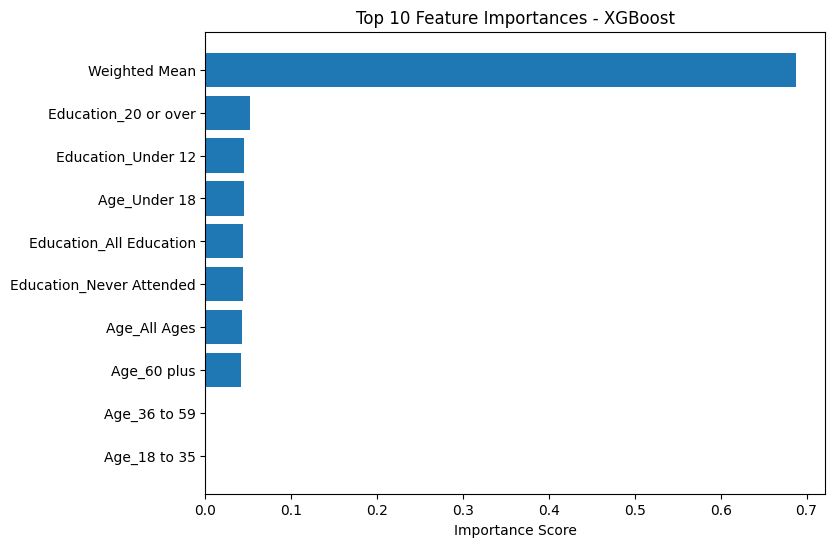

In [31]:
# ===== XGBoost Feature Importance =====
xgb_rs.fit(X_train, y_train)
best_xgb = xgb_rs.best_estimator_
pre = best_xgb.named_steps["preprocess"]
xgb_model = best_xgb.named_steps["model"]

# Numeric features
num_features = list(pre.transformers_[0][2])

# OneHotEncoder categorical features
ohe = pre.transformers_[1][1]
cat_input = pre.transformers_[1][2]  # ['Age','Education','Country','Category']
cat_features = list(ohe.get_feature_names_out(cat_input))

# Final feature names
feature_names = num_features + cat_features

# Create dataframe for ranking
import pandas as pd
import matplotlib.pyplot as plt

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n=== XGBoost Feature Importance ===")
print(fi_df.head(15))  # Top 15 features

# Plot (optional for report)
plt.figure(figsize=(8,6))
plt.barh(fi_df['Feature'][:10], fi_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.show()


Best Logistic Regression Params: {'model__C': np.float64(0.0157445582397843), 'model__class_weight': None, 'model__solver': 'newton-cg'}

=== Logistic Regression Coefficients Ranking ===
                     Feature  Coefficient       Abs
0              Weighted Mean     1.701148  1.701148
5               Age_Under 18     0.109782  0.109782
9   Education_Never Attended     0.081147  0.081147
6         Education_12 to 19    -0.063233  0.063233
4               Age_All Ages    -0.062724  0.062724
25     Country_Comoros (the)     0.062309  0.062309
7       Education_20 or over     0.059909  0.059909
8    Education_All Education    -0.058209  0.058209
1               Age_18 to 35    -0.037343  0.037343
2               Age_36 to 59    -0.035960  0.035960
63  Country_Papua New Guinea     0.033845  0.033845
82           Country_Vanuatu     0.029182  0.029182
72   Country_Solomon Islands     0.028816  0.028816
41             Country_Haiti    -0.026467  0.026467
3                Age_60 plus     

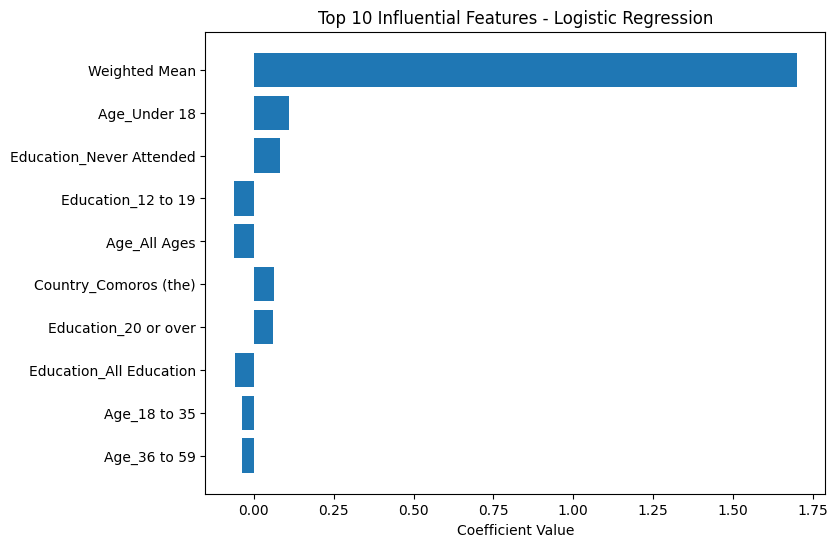

In [33]:
# ===================== Logistic Regression Training =====================
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

f1_pos_scorer = make_scorer(f1_score, pos_label=1)

log_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=33))
])

param_dist_lr = {
    "model__C": loguniform(0.0005, 5),
    "model__solver": ["liblinear", "lbfgs", "newton-cg"],
    "model__class_weight": [None, "balanced"]
}

lr_rs = RandomizedSearchCV(
    estimator=log_pipe,
    param_distributions=param_dist_lr,
    n_iter=20,
    scoring=f1_pos_scorer,
    cv=5,
    random_state=42,
    n_jobs=-1
)

lr_rs.fit(X_train, y_train)
best_lr = lr_rs.best_estimator_   # <--- IMPORTANT for feature importance use

print("Best Logistic Regression Params:", lr_rs.best_params_)

# ===== Logistic Regression Feature Importance (Coefficients) =====
log_model = best_lr.named_steps["model"]

coef = log_model.coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef,
})
coef_df["Abs"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs", ascending=False)

print("\n=== Logistic Regression Coefficients Ranking ===")
print(coef_df.head(15))

# Plot (optional)
plt.figure(figsize=(8,6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Influential Features - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.show()


# CLUSTERING ANALYSIS

In [34]:
# ================= Clustering Data Preparation =================

# Aggregate country-level climate attitude
country_df = df_target.groupby("Country").agg({
    "Weighted Mean": "mean",
    "support_strengthen": "mean"  # % of people supporting strengthen
}).reset_index()

country_df.rename(columns={
    "Weighted Mean": "avg_weighted_mean",
    "support_strengthen": "support_rate"
}, inplace=True)

print("\n=== Aggregated Country Attitude Data ===")
print(country_df.head())



=== Aggregated Country Attitude Data ===
       Country  avg_weighted_mean  support_rate
0  Afghanistan          25.661111          0.25
1      Algeria          24.455556          0.25
2    Argentina          24.400000          0.25
3    Australia          24.981250          0.25
4   Bangladesh          23.411111          0.25


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features to cluster on
features = ["avg_weighted_mean", "support_rate"]

X_cluster = country_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Run K-Means (k=3 is a good starting point, you can test 2-5 later)
kmeans = KMeans(n_clusters=3, random_state=42)
country_df["cluster"] = kmeans.fit_predict(X_scaled)

print("\n=== Country Cluster Output ===")
print(country_df.sort_values("cluster").head(20))



=== Country Cluster Output ===
                     Country  avg_weighted_mean  support_rate  cluster
0                Afghanistan          25.661111          0.25        0
1                    Algeria          24.455556          0.25        0
2                  Argentina          24.400000          0.25        0
3                  Australia          24.981250          0.25        0
7                     Bhutan          25.327778          0.25        0
6                      Benin          24.616667          0.25        0
11                    Canada          23.761111          0.25        0
8                     Brazil          24.055556          0.25        0
15                   Czechia          24.312500          0.25        0
12                     China          24.100000          0.25        0
13                  Colombia          25.194444          0.25        0
23                      Fiji          25.275000          0.25        0
20                     Egypt          24.4722

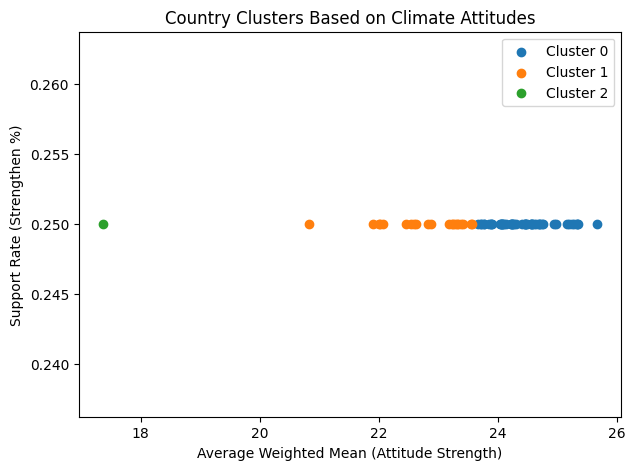

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for c in range(3):
    subset = country_df[country_df.cluster == c]
    plt.scatter(subset.avg_weighted_mean, subset.support_rate, label=f"Cluster {c}")

plt.xlabel("Average Weighted Mean (Attitude Strength)")
plt.ylabel("Support Rate (Strengthen %)")
plt.title("Country Clusters Based on Climate Attitudes")
plt.legend()
plt.show()


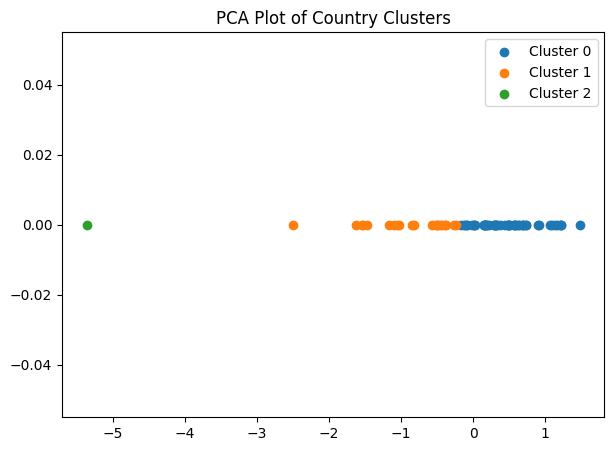

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_points = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
for c in range(3):
    subset = pca_points[country_df.cluster == c]
    plt.scatter(subset[:,0], subset[:,1], label=f"Cluster {c}")

plt.title("PCA Plot of Country Clusters")
plt.legend()
plt.show()


In [38]:
country_df = df_target.groupby("Country").agg({
    "Weighted Mean":"mean",
    "support_strengthen":"mean"
})


In [40]:
print(country_df)

                                                    Weighted Mean  \
Country                                                             
Afghanistan                                             25.661111   
Algeria                                                 24.455556   
Argentina                                               24.400000   
Australia                                               24.981250   
Bangladesh                                              23.411111   
...                                                           ...   
Uganda                                                  24.050000   
United Kingdom of Great Britain and Northern Ir...      24.750000   
United States of America (the)                          24.244444   
Vanuatu                                                 22.833333   
Zimbabwe                                                21.900000   

                                                    support_strengthen  
Country                      